<a href="https://colab.research.google.com/github/cs145442/nlp-projects-with-tf2/blob/master/sentiment_classification_with_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0.1 Handling the dependencies

In [22]:
# download the large model
! python3 -m spacy download en_core_web_lg

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [33]:
! pip install progressbar

  Created wheel for progressbar: filename=progressbar-2.5-cp36-none-any.whl size=12076 sha256=59f30d2e7ed9309f6822f5f5576d297927e0474b3ec1f28231095670ac3fa8f9
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built progressbar


In [41]:
# import all the dependencies here
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

from tensorflow.keras import layers

import pandas as pd

import math
import random
import spacy

# tools for progress bars
from IPython.display import HTML, display
import time

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import os
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Bidirectional
from keras.preprocessing import sequence
from keras.layers import Dropout

In [4]:
# second version of imports defined here
from keras.layers import Input
from keras.models import Model
from keras.layers.merge import Concatenate
from keras.utils import to_categorical

import matplotlib.pyplot as plt

## 0.2 Some helper functions

In [39]:
# pretty function to display the progess bar
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

## 1. Gathering the data

### 1.1 Getting the dataset

In [5]:
# add and unzip the dataset here
! ls
! wget http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
! unzip stanfordSentimentTreebank.zip

__MACOSX     stanfordSentimentTreebank	    stanfordSentimentTreebank.zip.1
sample_data  stanfordSentimentTreebank.zip
--2020-11-30 07:01:39--  http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip [following]
--2020-11-30 07:01:39--  https://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6372817 (6.1M) [application/zip]
Saving to: ‘stanfordSentimentTreebank.zip.2’

stanfordSentimentTr 100%[===================>]   6.08M  1.56MB/s    in 6.0s    

2020-11-30 07:01:46 (1.01 MB/s) - ‘stanfordSentimentTreebank.zip.2’ saved [6372817/6372817]

Archive:  stanfordSentimentTreeba

In [6]:
! cat stanfordSentimentTreebank/README.txt

Stanford Sentiment Treebank V1.0

This is the dataset of the paper:

Recursive Deep Models for Semantic Compositionality Over a Sentiment Treebank
Richard Socher, Alex Perelygin, Jean Wu, Jason Chuang, Christopher Manning, Andrew Ng and Christopher Potts
Conference on Empirical Methods in Natural Language Processing (EMNLP 2013)

If you use this dataset in your research, please cite the above paper.

@incollection{SocherEtAl2013:RNTN,
title = {{Parsing With Compositional Vector Grammars}},
author = {Richard Socher and Alex Perelygin and Jean Wu and Jason Chuang and Christopher Manning and Andrew Ng and Christopher Potts},
booktitle = {{EMNLP}},
year = {2013}
}

This file includes:
1. original_rt_snippets.txt contains 10,605 processed snippets from the original pool of Rotten Tomatoes HTML files. Please note that some snippet may contain multiple sentences.

2. dictionary.txt contains all phrases and their IDs, separated by a vertical line |

3. sentiment_labels.txt contains all phrase 

### 1.2 Exploring the dataset

In [7]:
# take a peek at the dataset format
! echo "----- contents of the treebank -------------------"
! ls stanfordSentimentTreebank
! echo "----- first 5 lines of dictionary.txt ------------"
! tail -n 5 stanfordSentimentTreebank/dictionary.txt
! echo "----- first 5 lines of sentiment_labels.txt ------"
! tail -n 5 stanfordSentimentTreebank/sentiment_labels.txt

----- contents of the treebank -------------------
datasetSentences.txt  dictionary.txt		README.txt	      SOStr.txt
datasetSplit.txt      original_rt_snippets.txt	sentiment_labels.txt  STree.txt
----- first 5 lines of dictionary.txt ------------
zoning ordinances to protect your community from the dullest science fiction|220441
zzzzzzzzz|179256
élan|220442
É|220443
É um passatempo descompromissado|220444
----- first 5 lines of sentiment_labels.txt ------
239227|0.36111
239228|0.38889
239229|0.33333
239230|0.88889
239231|0.5


In [8]:
# reading the dataset
dataset_df = pd.read_csv('stanfordSentimentTreebank/dictionary.txt', sep='\n')
dataset_df.head()

,!|0
0,! '|22935
1,! ''|18235
2,! Alas|179257
3,! Brilliant|22936
4,! Brilliant !|40532


In [9]:
# formatting the dataframe for processing
dataset_df['phrase_text'] = dataset_df['!|0'].apply(lambda x: x.split('|')[0])
dataset_df['phrase_ids'] = dataset_df['!|0'].apply(lambda x: x.split('|')[1])
dataset_df = dataset_df.drop('!|0', axis=1)

In [10]:
# take a peek at the dataframe
dataset_df.tail()

,phrase_text,phrase_ids
239226,zoning ordinances to protect your community fr...,220441
239227,zzzzzzzzz,179256
239228,élan,220442
239229,É,220443
239230,É um passatempo descompromissado,220444


In [11]:
# reading the sentiment data
sentiment_df = pd.read_csv('stanfordSentimentTreebank/sentiment_labels.txt', sep='\n')
sentiment_df.head()

,phrase ids|sentiment values
0,0|0.5
1,1|0.5
2,2|0.44444
3,3|0.5
4,4|0.42708


### 1.3 Formatting the dataset

In [12]:
# formatting the sentiment dataframe for processing
sentiment_df['phrase_ids'] = sentiment_df['phrase ids|sentiment values'].apply(lambda x: x.split('|')[0])
sentiment_df['sentiment_values'] = sentiment_df['phrase ids|sentiment values'].apply(lambda x: x.split('|')[1])
sentiment_df = sentiment_df.drop('phrase ids|sentiment values', axis=1)

In [13]:
sentiment_df.head()

,phrase_ids,sentiment_values
0,0,0.5
1,1,0.5
2,2,0.44444
3,3,0.5
4,4,0.42708


In [14]:
# let's merge the phrases and sentiments
dataset_sentiment_df = pd.merge(left=dataset_df, right=sentiment_df, how='inner', on='phrase_ids')
# let's also validate the number of datapoints
print(f"dataset df shape: {dataset_df.shape}")
print(f"sentiment df shape: {sentiment_df.shape}")
print(f"dataset_sentiment df shape: {dataset_sentiment_df.shape}")

dataset df shape: (239231, 2)
sentiment df shape: (239232, 2)
dataset_sentiment df shape: (239231, 3)


*seems good. we missed one datapoint while merging, that's okay for now.*

In [15]:
def recover_sentiment_class(sentiment_value: float):
  """
  recovering classes from sentiment_values
  [very negative, negative, neutral, positive, very positive]
  [0, 0.2], (0.2, 0.4], (0.4, 0.6], (0.6, 0.8], (0.8, 1.0]
  [0, 1, 2, 3, 4]
  respectively
  :params:
    sentiment_value: floating value of sentiment
  """
  if sentiment_value <= 0.2:
    return 0
  elif sentiment_value <= 0.4:
    return 1
  elif sentiment_value <= 0.6:
    return 2
  elif sentiment_value <= 0.8:
    return 3
  else:
    return 4

In [16]:
dataset_sentiment_df['sentiment_class'] = dataset_sentiment_df['sentiment_values'].apply(
    lambda x: recover_sentiment_class(float(x)))

In [17]:
dataset_sentiment_df.tail()

,phrase_text,phrase_ids,sentiment_values,sentiment_class
239226,zoning ordinances to protect your community fr...,220441,0.13889,0
239227,zzzzzzzzz,179256,0.19444,0
239228,élan,220442,0.51389,2
239229,É,220443,0.5,2
239230,É um passatempo descompromissado,220444,0.5,2


## 2. Generate Input Features

### 2.1 Generating the word vectors With Keras Tokenizer

In [66]:
phrase_max_length = len(max(list(dataset_df['phrase_text']), key=len))
print(f"phrase_max_length: {phrase_max_length}")

phrase_max_length: 267


*we've a phrase with max length of 267 characters*

In [ ]:
num_words = 3000
keras_tokenizer = Tokenizer(num_words=num_words, split=' ')
keras_tokenizer.fit_on_texts(dataset_sentiment_df['phrase_text'].values)
sequenced_dataset = keras_tokenizer.texts_to_sequences(dataset_sentiment_df['phrase_text'])
sequenced_dataset = pad_sequences(sequenced_dataset, padding='post', maxlen=phrase_max_length)

### 2.2 Generating the word vectors with Spacy large models

In [2]:
# loading the spacy model
spacy_large_model = spacy.load('en_core_web_lg')

In [42]:
# formatting all the phrase texts to a list
list_of_phrases = list(dataset_sentiment_df['phrase_text'])
# a new list to store the spacy tokens of all the sequences
list_of_phrases_spacy_tokens = list()
# count of all the phrases for progress bar
total_phrases = len(list_of_phrases)
# initalising the progress bar
out = display(progress(0, total_phrases), display_id=True)

# converting all the sequences to its spacy based tokens
for index, phrase in enumerate(list_of_phrases):
  out.update(progress(index, total_phrases))
  list_of_phrases_spacy_tokens.append(spacy_large_model(phrase))

we've converted each words to it's word2vec with spacy's large english model

In [48]:
list_of_oov_words = []
for phrases_spacy_tokens in list_of_phrases_spacy_tokens:
  for token in phrases_spacy_tokens:
    if token.is_oov:
      list_of_oov_words.append(token.text)
      print(token.text, end='\t')

Romething	8217	8217	8217	Cockettes	cockettes	cockettes	cockettes	cockettes	cockettes	flatula	Denlopp	flatula	Denlopp	Kaputschnik	Feardotcom	Kaputschnik	Hennings	untugged	Kaputschnik	powerment	Vardalos	Vardalos	Morvern	Callar	Morvern	Callar	precollegiate	Nebrida	Nebrida	Laurice	Nebrida	Laurice	Nebrida	Laurice	Nebrida	Laurice	X	X	Copmovieland	mark	Picpus	Ohlinger	adventues	LePlouff	LePlouff	76-minute	waydowntown	waydowntown	Nettelbeck	Nettelbeck	Zishe	Hanussen	Zishe	Hanussen	Truckzilla	Truckzilla	Truckzilla	Truckzilla	Truckzilla	Truckzilla	Truckzilla	Kaputschnik	Kaputschnik	number	likably	Phocion	Phocion	age\/coming	age\/coming	musclefest	musclefest	musclefest	musclefest	musclefest	musclefest	musclefest	Shagster	Shagster	Schwentke	Schwentke	psychodramatics	psychodramatics	hastier	Bjorkness	Bjorkness	unfussily	unfussily	mother\/daughter	mother\/daughter	and\/or	and\/or	sitcomishly	sitcomishly	sitcomishly	democracie	Muccino	Muccino	muccino	muccino	Jacquot	Jacquot	Toback	Toback	mark	mark	te

we've identified which words are out of vocabulary of our spacy en lg model

In [94]:
print(f"Count of Out of Vocabulary words: {len(list_of_oov_words)}")

Count of Out of Vocabulary words: 8192


### 2.2 Generating the POS Tags
*Indicates the part-of-speech tag of the word*

In [63]:
def get_pos_tags(doc: spacy.tokens.doc.Doc):
  """
  returns a list of token's POS Tags
  """
  # generator of pos tags for the sequence or word
  tags = []
  for token in doc:
    tags.append(token.pos_)
  return tags


dict_of_pos_tags = {}
def get_pos_tag2id(pos_tag: str):
  """
  returns the id for the POS Tag from the universal dict of POS Tags
  """
  id = dict_of_pos_tags.get(pos_tag, None)
  if id is None:
    # i.e, POS Tag is not in the dict
    # Add the new POS Tag to the dict
    new_id = len(dict_of_pos_tags) + 1
    dict_of_pos_tags[pos_tag] = new_id
    return new_id
  else:
    return id


def get_pos_tag_ids(doc: spacy.tokens.doc.Doc):
  """
  returns a list of token's POS Tags ID's
  """
  tag_ids = []
  for token in doc:
    tag_ids.append(get_pos_tag2id(token.pos_))
  return tag_ids

In [64]:
list_of_phrases_pos_tags = [get_pos_tags(phrase) for phrase in list_of_phrases_spacy_tokens]
list_of_phrases_pos_tag_ids = [get_pos_tag_ids(phrase) for phrase in list_of_phrases_spacy_tokens]

In [67]:
sequenced_pos_tag_ids = pad_sequences(list_of_phrases_pos_tag_ids, padding='post', maxlen=phrase_max_length)

In [68]:
sequenced_pos_tag_ids.shape

(239231, 267)

### 2.3 Generate the word shape
*Indicates whether a word start with a captial letter?*

In [90]:
def get_init_word_case_match(doc: spacy.tokens.doc.Doc):
  """
  returns a list of token's initial case match indicator
  indicators: 1 if the token begins with an UPPERCASE letter
  indicators: 2 if the token begins with an lowercase letter
  """
  init_word_case_match = []
  for token in doc:
    init_word_case_match.append(1 if token.text.istitle() else 2)
  return init_word_case_match

In [91]:
list_of_phrases_init_word_case_match = [get_init_word_case_match(phrase) for phrase in list_of_phrases_spacy_tokens]

In [92]:
sequenced_word_case_match = pad_sequences(list_of_phrases_init_word_case_match, padding='post', maxlen=phrase_max_length)

### 2.4 Generate the word end match sequence
*Indicates whether a word end with an “ing” or with “ly” or neither?*

In [85]:
def indicate_word_ending(doc: spacy.tokens.doc.Doc):
  """
  returns a list of token's word ending match inidicator
  indicators: 1 if word ends with 'ing'
  indicators: 2 if word ends with 'ly'
  indicators: 3 if word ends with neither of previous two endings
  """
  word_end_match = []
  for token in doc:
    if token.text.endswith('ly'):
      word_end_match.append(1)
    elif token.text.endswith('ing'):
      word_end_match.append(2)
    else:
      word_end_match.append(3)
  return word_end_match

In [87]:
list_of_phrases_word_end_match = [indicate_word_ending(phrase_spacy_tokens) for phrase_spacy_tokens in list_of_phrases_spacy_tokens]

In [88]:
sequenced_list_of_phrases_word_end_match = pad_sequences(list_of_phrases_word_end_match, padding='post', maxlen=phrase_max_length)

## 3. Sentiment Analysis 

*splitting the dataset for training and testing*

In [ ]:
X_train, X_test, X_POS_train, X_POS_test, X_word_case_train, X_word_case_test, X_lemma_train, X_lemma_test, y_train, y_test = train_test_split(
    sequenced_dataset,
    sequenced_pos_tag_ids,
    sequenced_word_case_match,
    sequenced_lemma_match,
    dataset_sentiment_df['sentiment_class'],
    test_size = 0.40,
    random_state = 42
    )

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

*defining all the hyperparameters here*

In [ ]:
# define hyperparams here
vocab_size = num_words + 1
embed_dim = 128
lstm_neurons = 196
output_classes_count = 5

*defining the model layers here*

In [ ]:
# input layer for encoded phrases
input_1 = Input(shape=(phrase_max_length,))
embedding_layer = Embedding(vocab_size, embed_dim)(input_1)
lstm_layer_1 = LSTM(lstm_neurons)(embedding_layer)

# input layer for pos tag id's of phrases
input_2 = Input(shape=(phrase_max_length,))
dense_layer_1 = Dense(10, activation='relu')(input_2)
dense_layer_2 = Dense(10, activation='relu')(dense_layer_1)

# input layer for phrase init word case match
input_3 = Input(shape=(phrase_max_length,))
dense_layer_3 = Dense(10, activation='relu')(input_3)
dense_layer_4 = Dense(10, activation='relu')(dense_layer_3)

# input layer for phrase lemma match
input_4 = Input(shape=(phrase_max_length,))
dense_layer_5 = Dense(10, activation='relu')(input_4)
dense_layer_6 = Dense(10, activation='relu')(dense_layer_5)

concat_layer = Concatenate()([lstm_layer_1, dense_layer_2, dense_layer_4, dense_layer_6])
dense_layer_7 = Dense(10, activation='relu')(concat_layer) 
# [1, 2, 3, 4, 5, 6, 7, 8, 9, 0] -> set_representation([0, 1])
output = Dense(output_classes_count, activation='softmax')(dense_layer_7)
model = Model(inputs=[input_1, input_2, input_3, input_4], outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 267)]        0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 267)]        0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 267)]        0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, 267)]        0                                            
______________________________________________________________________________________

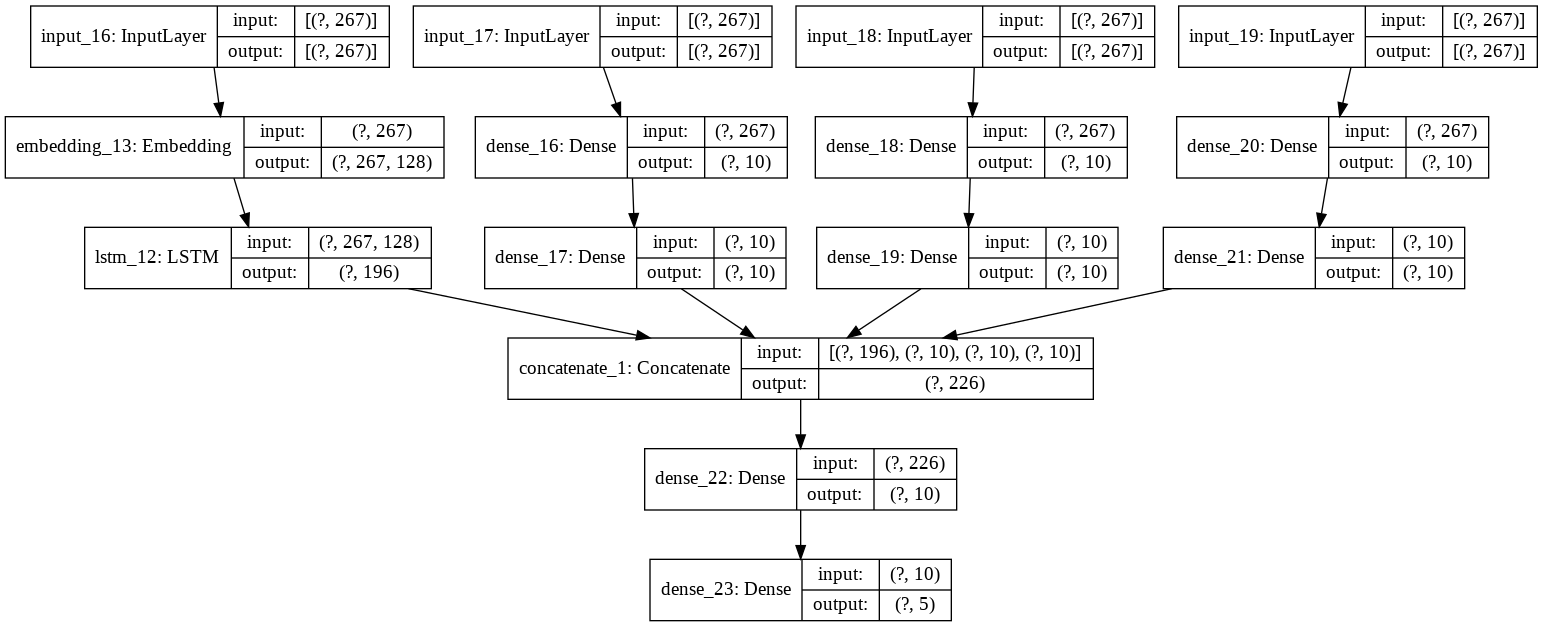

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot1.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit([X_train, X_POS_train, X_word_case_train, X_lemma_train], y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.3)

Epoch 1/10
785/785 [==============================] - 38s 48ms/step - loss: 1.2519 - accuracy: 0.4994 - val_loss: 1.2354 - val_accuracy: 0.5043
Epoch 2/10
785/785 [==============================] - 37s 47ms/step - loss: 1.2341 - accuracy: 0.5009 - val_loss: 1.2285 - val_accuracy: 0.5047
Epoch 3/10
785/785 [==============================] - 37s 47ms/step - loss: 1.2297 - accuracy: 0.5015 - val_loss: 1.2282 - val_accuracy: 0.5049
Epoch 4/10
785/785 [==============================] - 37s 47ms/step - loss: 1.2268 - accuracy: 0.5016 - val_loss: 1.2247 - val_accuracy: 0.5061
Epoch 5/10
785/785 [==============================] - 37s 47ms/step - loss: 1.2253 - accuracy: 0.5006 - val_loss: 1.2224 - val_accuracy: 0.5067
Epoch 6/10
785/785 [==============================] - 37s 47ms/step - loss: 1.2231 - accuracy: 0.5022 - val_loss: 1.2233 - val_accuracy: 0.5073
Epoch 7/10
785/785 [==============================] - 37s 47ms/step - loss: 1.2216 - accuracy: 0.5021 - val_loss: 1.2207 - val_accuracy:

*with multiple features, accuracy amps up to* **50.34%** 

In [ ]:
model.evaluate([X_test, X_POS_test, X_word_case_test, X_lemma_test], y_test)

2991/2991 [==============================] - 24s 8ms/step - loss: 1.2155 - accuracy: 0.5053


[1.2154918909072876, 0.5053138732910156]

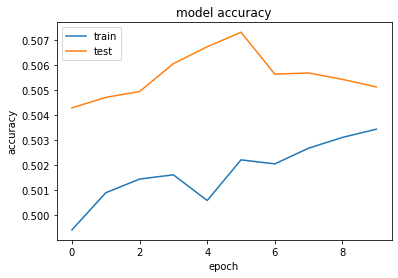

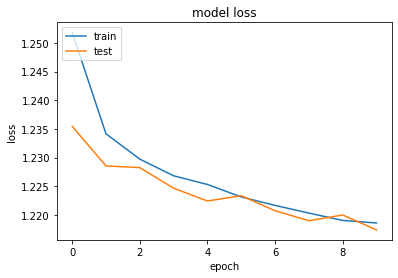

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

we observe that 

1.   the training accuracy reduces after epoch=6 at batch_size=128, however the loss keeps on decreasing
2.   the accuracy can be improved with more hyperparameter tuning (ongoing experimentation with keras tuner can be found at this [link](https://github.com/cs145442/nlp-projects-with-tf2/blob/master/training_with_keras_tuner.ipynb))
